# Predicting high-traffic recipes to boost user engagement

## 1. Project goals and approach

**Business problem**  

The goal is to increase subscriptions and user engagement on a recipe website by identifying which recipes will attract high web traffic. The objective is to correctly predict high-traffic recipes at least 80% of the time.

**Approach**  

- Data validation and cleaning
- Exploratory data analysis (EDA)
- Feature engineering and target construction
- Classification model development
- Model evaluation
- Business metric alignment
- Final recommendations

In [22]:
# Load libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [23]:
# Load dataset
import pandas as pd

# Load the dataset 
df = pd.read_csv('recipe_site_traffic_2212.csv')

# Preview the data
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# 2. Data validation

**Data overview**

I want to provide a summary of the dataset, including key descriptive statistics, the structure of the data, and any relevant information that helps to understand its contents. 

In [24]:
# info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


We can already say from this output that there are missing values in columns calories, carbohydrate, sugar, protein and more that 300 missing values on high_traffic. "servings" column should numeric, but we can see it is an object, so we have to correct all of the problems.

In [25]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64


In [26]:
# Summary statistics
df.describe(include='all')

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,NaN,106,389,574
mean,474.000000,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,273.519652,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,1.000000,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,237.500000,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,474.000000,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,710.500000,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


Interpretation of the info and the summary statistics.

*   recipe: There is 947 values from 1 to 947 and it is a numeric column. There is no missing values. We have to check the uniqueness
*  calories:	It is a numeric column with no negative values but it has 52 missing values. We have to impute missing values. 
*  carbohydrate, sugar	Mean, protein	Mean: similar to calories
*  category: It is an object, and there is no missing values but there is 11 unique values found instead of 10 (as specified in the instructions). We have to investigate this
* servings: There is no missing values. It is an object but should be numeric. We have to investigate this
* high_traffic: Only 574 values labeled as "High" missing in 373 rows, so all the remaining rows are missing. Based on the description, all the rows where high_traffic is missing are simply ones where traffic was not high. We assume missing = Not High.

Handling possible outliers

*  calories: Min =0.14, a very low value for calories, possibly a data entry issue or an outlier.Max =3633.16, an extremely high value, which is very likely an outlier, as most recipes should have a reasonably normal range for calorie content.
*  carbohydrated high variability, max 530g is likely an outlier. Median = 21g, so mean (35g) is pulled by skewed data. 
*  sugar	Mean = 9g, but max = 149g, again likely a few recipes with very high sugar pulling average up. 
* protein	Mean = 24g, but max = 363g — an extreme outlier (most recipes < 30g). Might distort models if not handled. 

We'll apply the IQR method to detect and handle these outliers.

Anything above Q3 + 1.5 x IQR is an outlier

Anything below Q1 - 1.5 x IQR is an outlier


**Validation and cleaning steps for every column**

In [27]:
# we will use a function so that we won't have to write the same code 4 times
import numpy as np

# Define a function to remove outliers based on IQR
def remove_outliers(df, column):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for non-outlier values
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the dataframe to keep only non-outlier rows
    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_clean

# Remove outliers from the relevant columns
columns_with_outliers = ['calories', 'carbohydrate', 'sugar', 'protein']
for column in columns_with_outliers:
    df = remove_outliers(df, column)

# Check the data after removing outliers
print(df.describe(include='all'))


            recipe     calories  carbohydrate       sugar     protein  \
count   662.000000   662.000000    662.000000  662.000000  662.000000   
unique         NaN          NaN           NaN         NaN         NaN   
top            NaN          NaN           NaN         NaN         NaN   
freq           NaN          NaN           NaN         NaN         NaN   
mean    479.246224   364.487674     26.050906    5.401133   15.562281   
std     274.565962   320.849401     23.278106    4.995607   16.646305   
min       2.000000     0.300000      0.030000    0.010000    0.000000   
25%     245.250000    96.272500      7.542500    1.565000    2.882500   
50%     485.500000   267.060000     19.180000    3.835000    9.525000   
75%     718.500000   543.647500     38.635000    7.880000   23.037500   
max     947.000000  1321.780000    100.700000   22.390000   71.880000   

         category servings high_traffic  
count         662      662          390  
unique         11        5            1

**Validation and cleaning steps for every column**

In [28]:
# Validation for recipe, possible 662 values
df['recipe'].nunique()

662

For calories, I will use the median per category so that a missing calorie value in a category of dish will be filled with the typical calorie value for this category of dish and not for all the recipes, ensuring more accurate and context-specific estimates. .

The same approach will be used for the other nutritional values (carbohydrate, sugar, protein) that have the same validation issue as calories.

But first, we will do the validation of category column before using it for imputation



For the category column, there is no missing values, and the type is object. However, in the instructions, we see there is 10 unique values but in the summary we found 11. Lets' check this

In [29]:
# Values of category
df['category'].unique()

array(['Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Pork', 'Vegetable', 'Meat',
       'Chicken', 'Dessert'], dtype=object)

Let's replace 'Chicken Breast' by 'Chicken' so that it does match the requirements

In [31]:
# Replace 'Chicken Breast' by 'Chicken'
df['category'] = df['category'].replace("Chicken Breast","Chicken")

In [32]:
# Validation for category
df['category'].unique()

array(['Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken',
       'Lunch/Snacks', 'Pork', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

There is no missing values anymore in the column_with_outliers treated. But I run the following code just in case 

In [33]:
# Impute missing values using category-specific medians
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[col] = df.groupby('category')[col].transform(
        lambda x: x.fillna(x.median())
    )

In [34]:
# Validation, check for missing values
print("\nMissing values:")
print(df[['calories', 'carbohydrate', 'sugar', 'protein']].isnull().sum())


Missing values:
calories        0
carbohydrate    0
sugar           0
protein         0
dtype: int64


In [35]:
# Values of servings
print(df['servings'].unique())

['4' '1' '2' '6' '4 as a snack']


In [36]:
# Cleaning of servings
def clean_servings(x):
    # Remove known text like "as a snack"
    x = re.sub(r'as a snack', '', x)
    x = x.strip()
    return int(x)

# Apply updated cleaning
df['servings'] = df['servings'].apply(clean_servings)


In [37]:
# Validation of servings
print(df['servings'].unique())
print(df['servings'].dtype)

[4 1 2 6]
int64


In [38]:
# Fill missing of high_traffic values as "Not High"
df['high_traffic'] = df['high_traffic'].fillna('Not High')

In [39]:
# Validation of high_traffic
print(df['high_traffic'].unique())

['High' 'Not High']


With these cleaning steps, the dataset is now ready for exploratory analysis, model development, and further decision-making based on more reliable and consistent data

# Exploratory analysis

**Distribution of the target variable 'high_traffic'** 

high_traffic
High        58.912387
Not High    41.087613
Name: proportion, dtype: float64


C:\Users\mamyd\AppData\Local\Temp\ipykernel_31392\3576287154.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='high_traffic', data=df, palette='Set2')


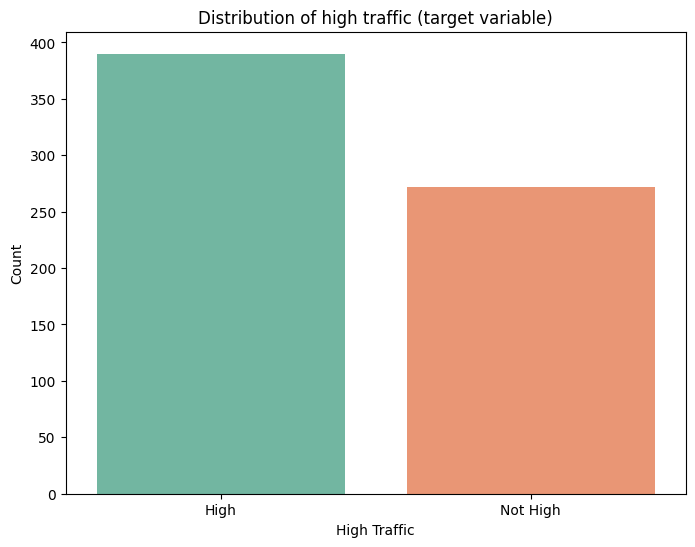

In [43]:
# Plotting the distribution of the target variable 'high_traffic'
plt.figure(figsize=(8, 6))

# Count plot
sns.countplot(x='high_traffic', data=df, palette='Set2')
plt.title('Distribution of high traffic (target variable)')
plt.xlabel('High Traffic')
plt.ylabel('Count')

# Display percentages
high_traffic_percentage = df['high_traffic'].value_counts(normalize=True) * 100
print(high_traffic_percentage)

plt.show()

The chart clearly shows that the "High" traffic category has a significantly higher count than the "Not High" traffic category.

In other words, the website experiences "High" traffic more frequently than "Not High" traffic.

When evaluating models built on this kind of data, it's essential to consider metrics beyond simple accuracy, as accuracy can be misleading in imbalanced datasets. Metrics like precision, recall, F1-score, and AUC (Area Under the ROC Curve) are more appropriate for assessing model performance in such scenarios.

**Distribution of each nutritional variable**

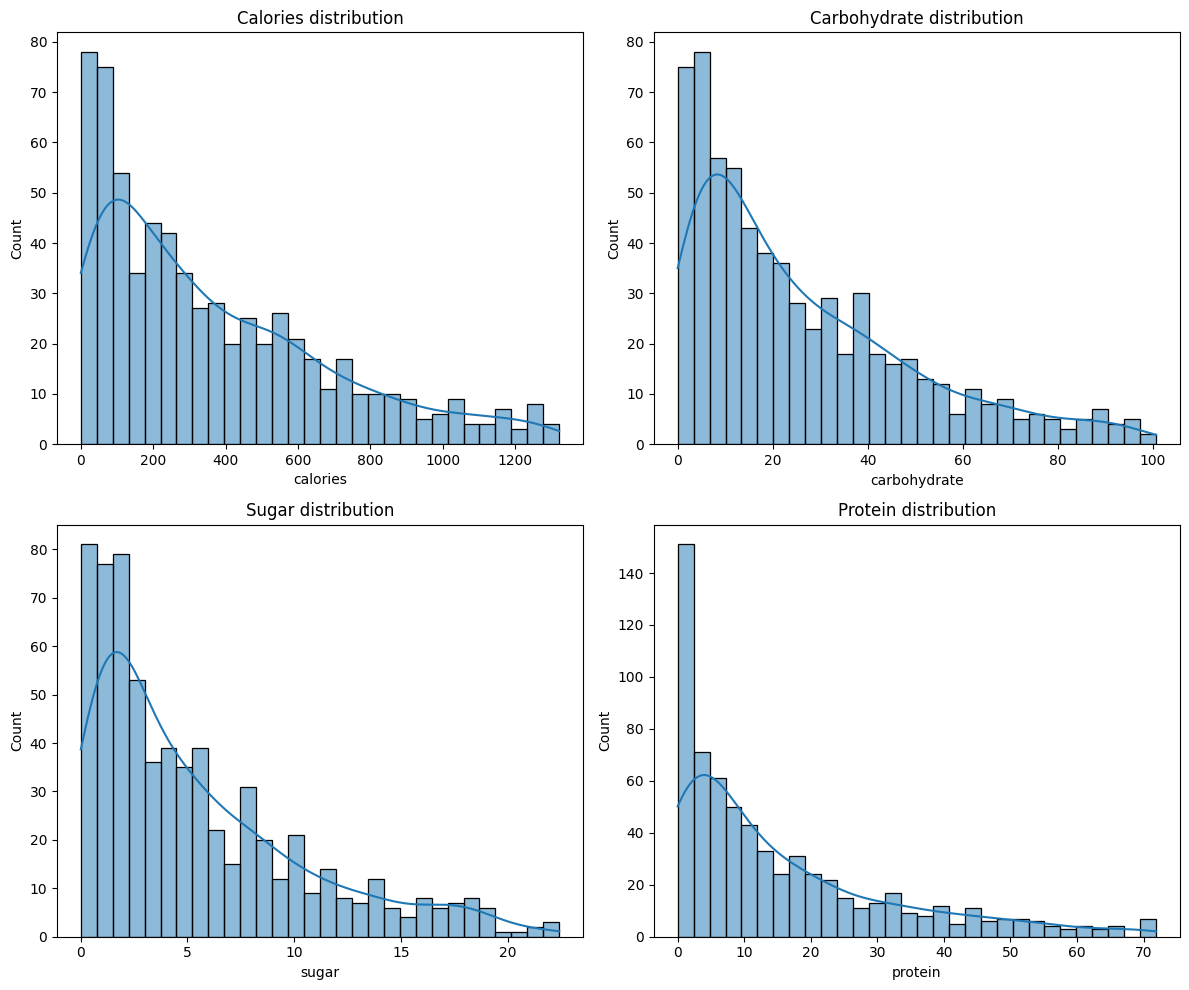

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms for the nutritional variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['calories'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Calories distribution')

sns.histplot(df['carbohydrate'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Carbohydrate distribution')

sns.histplot(df['sugar'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Sugar distribution')

sns.histplot(df['protein'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Protein distribution')

plt.tight_layout()
plt.show()


- Calories distribution: right-skewed, the majority of recipes in the dataset are relatively low in calories, but there's a significant number of recipes with higher calorie counts. 
- Carbohydrate distribution: right-skewed. Most recipes have relatively low carbohydrate content, but there's a range of recipes with higher carbohydrate levels. 
- Sugar distribution: right-skewed, the majority of recipes have low sugar content. However, there's a noticeable presence of recipes with higher sugar levels, maybe desserts.
- Protein distribution: right-skewed, Most recipes have low protein content, but there's a wide range of recipes with higher protein levels. 

**Traffic vs nutritional variables**

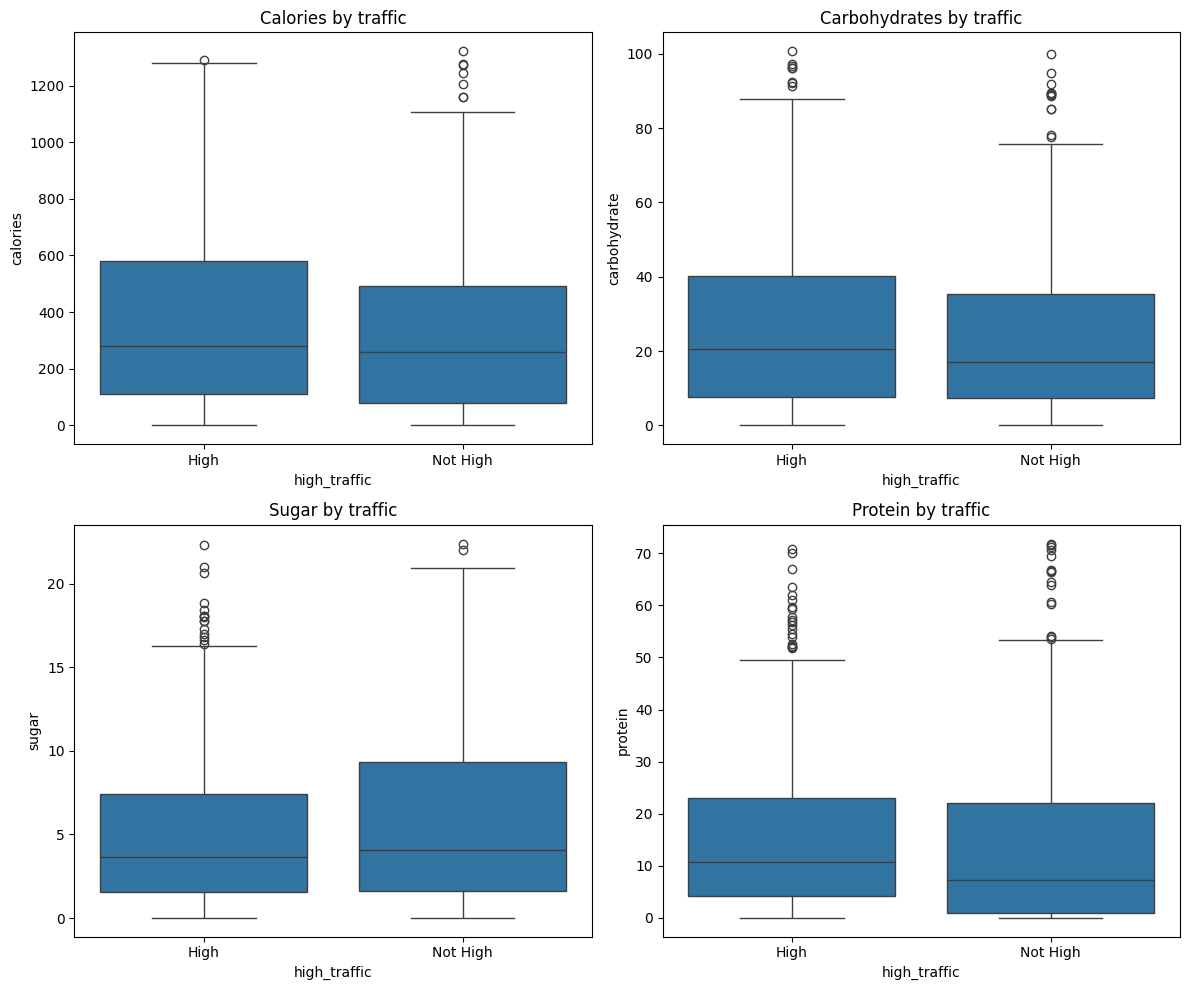

In [41]:
# Boxplots for comparing high_traffic with nutritional variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(x='high_traffic', y='calories', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Calories by traffic')

sns.boxplot(x='high_traffic', y='carbohydrate', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Carbohydrates by traffic')

sns.boxplot(x='high_traffic', y='sugar', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Sugar by traffic')

sns.boxplot(x='high_traffic', y='protein', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Protein by traffic')

plt.tight_layout()
plt.show()


High traffic seems to correlate with recipes higher in calories, carbohydrates, and protein, while lower traffic is associated with recipes higher in sugar.
However, the correlation is not very strong

**Category vs Traffic**

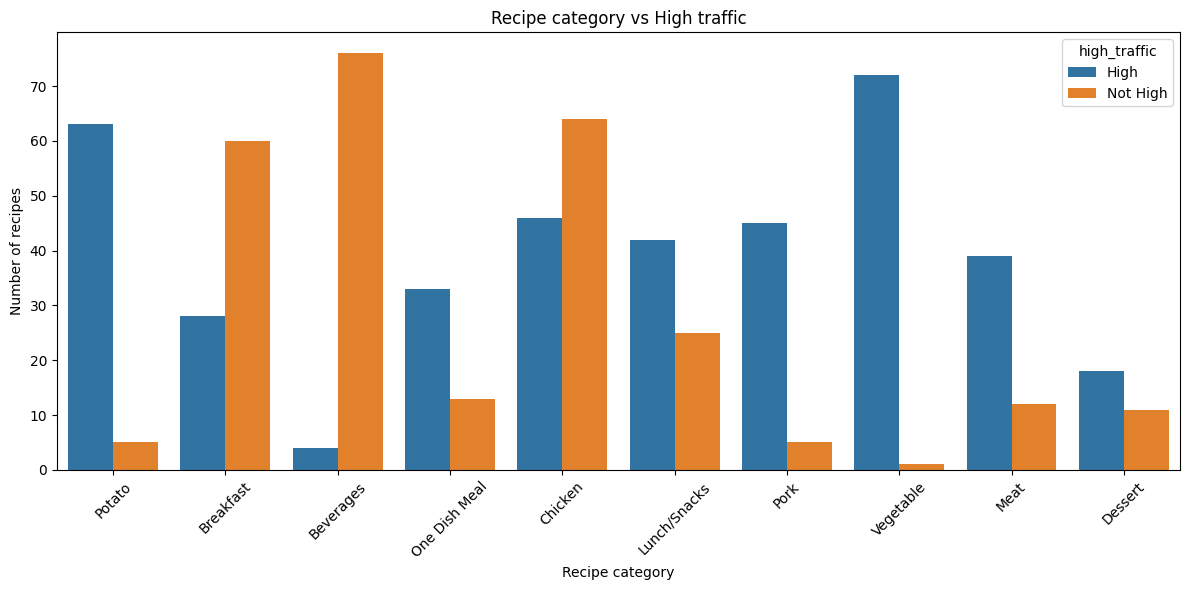

In [42]:
# Recipe Category vs High Traffic Status
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(data=df, x='category', hue='high_traffic')
plt.title('Recipe category vs High traffic')
plt.xticks(rotation=45)
plt.xlabel('Recipe category')
plt.ylabel('Number of recipes')
plt.tight_layout()
plt.show()

Categories with higher "High Traffic" counts: Vegetable, Potato, Pork, Meat, One Dish Meal, Lunch/Snacks. These categories may be more engaging or popular with users.
Categories with higher "Not High" counts: Beverages, Breakfast, suggesting they are less popular or do not attract as much interest.
Mixed Categories:
Chicken: Although it has many high traffic recipes, it’s fairly balanced with Not high traffic, suggesting it performs moderately well overall.
Dessert: Even if the "High Traffic" count is slightly higher, the difference is small and there is less recipes in the category Dessert than in other categories

# Model development and evaluation

Predicting wether a recipe will be associated with High or not high is a classification problem. The target variable is high_traffic, which is categorical with two classes: High and Not High.

we built a baseline model using **Logistic Regression** due to its simplicity and interpretability. Logistic regression is a linear model used for binary classification.

we built a comparison model using **Random Forest** which is an ensemble learning method based on decision trees. It's capable of capturing non-linear relationships and interactions between nutritional variables. It's robust to outliers and can handle noisy data effectively. This is important in our case, as even after IQR outlier handling, there might still be some variability in the data.


**Prepare data for modeling**

We will make changes to enable modeling: 

*   transform high_traffic to binary
*   encode categorical variables
*   choose the features ans target
*   split the data



In [44]:
# transform high_traffic to binary
df['high_traffic_encoded'] = df['high_traffic'].map({'Not High': 0, 'High': 1})
# Reset index to avoid alignment issues during concat
df = df.reset_index(drop=True)
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,high_traffic_encoded
0,2,35.48,38.56,0.66,0.92,Potato,4,High,1
1,3,914.28,42.68,3.09,2.88,Breakfast,1,Not High,0
2,5,27.05,1.85,0.80,0.53,Beverages,4,Not High,0
3,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High,1
4,7,183.94,47.95,9.75,46.71,Chicken,4,Not High,0


In [45]:
# encode categorical variables
ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid dummy variable trap
category_encoded = ohe.fit_transform(df[['category']])

# Add encoded columns to the dataframe
category_encoded_df = pd.DataFrame(category_encoded, columns=ohe.get_feature_names_out(['category']))

In [46]:
# Reset index of category_encoded_df to match df before concatenation
category_encoded_df.reset_index(drop=True, inplace=True)

# Combine with main DataFrame
df_model = pd.concat([df.drop(['category', 'high_traffic'], axis=1), category_encoded_df], axis=1)
df_model.head()

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic_encoded,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
0,2,35.48,38.56,0.66,0.92,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3,914.28,42.68,3.09,2.88,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,27.05,1.85,0.80,0.53,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,691.15,3.46,1.65,53.93,2,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7,183.94,47.95,9.75,46.71,4,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Define features (X) and target (y)
X = df_model.drop('high_traffic_encoded', axis=1)
y = df_model['high_traffic_encoded']

In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

### Logistic regression model

In [ ]:
# Baseline model: Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Results ")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

Logistic Regression Results 
Accuracy: 0.7293233082706767
              precision    recall  f1-score   support

           0       0.71      0.61      0.66        57
           1       0.74      0.82      0.78        76

    accuracy                           0.73       133
   macro avg       0.73      0.71      0.72       133
weighted avg       0.73      0.73      0.73       133

Confusion Matrix:
 [[35 22]
 [14 62]]


c:\Users\mamyd\personal_projects\ds_portfolio\ds-projects-nmd\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic regression performance summary:**

The model correctly predicts high_traffic about 72,9% of the time.

Precision (High Traffic): Of all the times the model predicted "High Traffic", 74% were actually correct.

Recall (High Traffic): The model correctly identified 82% of all actual "High Traffic" instances.

Model tends to do better at identifying “High Traffic”, which may be beneficial if that’s the more important class for business decisions.

### Random Forest model

In [51]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Results
Accuracy: 0.706766917293233
              precision    recall  f1-score   support

           0       0.69      0.58      0.63        57
           1       0.72      0.80      0.76        76

    accuracy                           0.71       133
   macro avg       0.70      0.69      0.69       133
weighted avg       0.70      0.71      0.70       133

Confusion Matrix:
 [[33 24]
 [15 61]]


**Random forest performance summary:**

The model correctly predicts high_traffic about 70,7% of the time.

Precision (High Traffic): Of all the times the model predicted "High Traffic", 72% were actually correct.

Recall (High Traffic): The model correctly identified 80% of all actual "High Traffic" instances.

Model also tends to do better at identifying “High Traffic”

### Model comparison

In terms of accuracy, Logistic Regression is slightly better, with an accuracy of 72.9%, while Random Forest has 70.68%.

Both models have fairly similar precision (74% for Logistic Regression and 72% for Random Forest) and recall (at least 80% for both models (80-82)). This means that both models are relatively good at identifying high-traffic recipes (80% recall), with only a small drop in precision. This indicates that while both models correctly identify high-traffic recipes most of the time, they do tend to misclassify some low-traffic recipes as high-traffic.

Both models have an F1-score of 76% for predicting high-traffic recipes, which suggests that they strike a good balance between precision and recall.


# Business metrics

compare model performance to the business:

To monitor the business goal, we recommend using the Recall metric as the KPI. This is because the goal is to capture as many high-traffic recipes as possible, even at the expense of some false positives. By maximizing recall, the business will be more likely to showcase recipes that generate high traffic, which ultimately leads to increased subscriptions.
Both models are performing slightly at the same level, correctly identifying high-traffic recipes 80% of the time, which aligns with the goal of 80% accuracy for high-traffic predictions.

# Final summary including recommendations that the business should undertake

- Given the similar performance of both models, the Random Forest model is recommended for deployment. Although it is slightly less accurate than Logistic Regression, it is more robust due to its ability to handle complex relationships between features, making it more adaptable to different recipe attributes.

- Given that the business aims to showcase high-traffic recipes, it is critical to track recall as the primary metric. This will help ensure that the homepage is populated with recipes most likely to lead to higher traffic and engagement.

- Continuous Model Improvement: While the models are performing at 80% recall, there may still be room for improvement. Consider further fine-tuning the models, and incorporating additional features like user preferences or seasonal trends (if existing) that could affect traffic patterns.

Test Real-World Scenarios: It is important to test these models in a real-world scenario. Deploying them in a live environment where they can be tested against actual traffic data.

### Final summary
Both the Logistic Regression and Random Forest models perform well, with recall at 80%. Given the results, the business should proceed with deploying the Random Forest model for predicting high-traffic recipes. Moving forward, the business should focus on maximizing recall while exploring ways to further optimize the model's performance.